# Pneumonia detection

This notebook contains the implementation of a Convolutional Neural Network built with [PyTorch](https://pytorch.org/) and fine tuned uppon the pre-trained [ResNet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#resnet18) model to work on medical disgnosis of penumonia disease support.

| |
| ----------- |
| **Author**: Hebert Costa \| [@hjcostabr76](https://github.com/hjcostabr76)      |
| Available on [Github](https://github.com/hjcostabr76/ml/blob/master/classification/case-peneumonia/nb_pneumonia.ipynb) |
| See also [this](https://github.com/hjcostabr76/ufmg-pdetect) simple prototype that demonstrates a possible real world use of this model applied |

Imports

In [ ]:
'''
    Run this in case the following imports don't run.
    !pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
'''
import time
import copy
import os
import cv2
import random
import torch

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from collections import Counter
from sklearn.metrics import roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay, f1_score

from torchvision import transforms, datasets, models
from torchvision.transforms.functional import InterpolationMode

from torch import optim
from torch.utils.data import DataLoader, WeightedRandomSampler


### Parameters

To run the following cells beware of the google drive root path definition.

##### About Hiper Parameters

Through the exploration of the problem five sets of hyperparameters were tested. We see each of these below with their respective result performance metrics _(1st model data has been lost. But it was the worst one)_.

As we can see, the performance of the model improved as more combinations were experimented.

__Version 02__

------------------------------------------------------------------------

Hyper Parameters:

```
version = '02'
n_epochs = 4
w_decay = 1e-3
momentum = 0.9
batch_size = 32
learn_rate = 0.001
optim_algorithm = 'adam'

transf_crop = 54
transf_resize_test = 54
transf_resize_train = 60
```

Test Results

    Accuracy: 0.8798
    Precision (average): 0.9461
    Recall (average): 0.6175
    F1 Score (Normal): 0.8555
    F1 Score (Pneumonia): 0.8971


__Version 03__

------------------------------------------------------------------------

Hyper Parameters:

```
n_epochs = 4
w_decay = 1e-3
momentum = 0.9
batch_size = 32
learn_rate = 0.001
optim_algorithm = 'adam'

transf_crop = 224
transf_resize_test = 230
transf_resize_train = 255
```

Test Results

    Accuracy: 0.9215
    Precision (average): 0.9476
    Recall (average): 0.6139
    F1 Score (Normal): 0.8960
    F1 Score (Pneumonia): 0.9369


__Version 04__

------------------------------------------------------------------------

Hyper Parameters:

```
n_epochs = 4
w_decay = 1e-3
momentum = 0.9
batch_size = 32
learn_rate = 0.001
optim_algorithm = 'sgd'

transf_crop = 224
transf_resize_test = 230
transf_resize_train = 255
```

Test Results

    Accuracy: 0.9279
    Precision (average): 0.9471
    Recall (average): 0.5994
    F1 Score (Normal): 0.8993
    F1 Score (Pneumonia): 0.9438


__Version 05__

------------------------------------------------------------------------

Hyper Parameters:

```
n_epochs = 4
w_decay = 1e-3
momentum = 0.9
batch_size = 128
learn_rate = 0.001
optim_algorithm = 'sgd'

transf_crop = 224
transf_resize_test = 230
transf_resize_train = 255
```

Test Results

    Accuracy: 0.9135
    Precision (average): 0.9255
    Recall (average): 0.6321
    F1 Score (Normal): 0.8789
    F1 Score (Pneumonia): 0.9327

##### **Definition**

In [ ]:

version = '05'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper Parameters
n_epochs = 4
w_decay = 1e-3
momentum = 0.9
batch_size = 128
learn_rate = 0.001
optim_algorithm = 'sgd'

transf_crop = 224
transf_resize_test = 230
transf_resize_train = 255

# Paths
path_dir_data = "/content/drive/MyDrive/Colab Notebooks/pneumonia/file/chest_xray" # Change it!
path_dir_val = os.path.join(path_dir_data, 'val')
path_dir_test =  os.path.join(path_dir_data, 'test')
path_dir_train =  os.path.join(path_dir_data, 'train')
path_dir_train_pneumonia = os.path.join(path_dir_train, 'PNEUMONIA')
path_dir_models = os.path.join(path_dir_data, f'models/model_{version}')

path_file_model = os.path.join(path_dir_models, f'model_{version}.pt')
path_file_roc_recall = os.path.join(path_dir_models, f'model_{version}-roc-recall.png')
path_file_conf_matrix = os.path.join(path_dir_models, f'model_{version}-conf-matrix.png')

DEVICE

device(type='cuda', index=0)

## Prepare data

#### Colab only...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load dataset

Dataset is downloaded dynamically if you don't have it already in your Google drive.

##### **Data Augmentationn $+$ Data Balancing**

To improve the variability of data seen by the model along the training we use PyTorch's data transformation pipelines API.

Besides that our data is unbalanced as we can check on the following cells. To reduce the risk of biasing our model we face this matter using the stratagy of weighting data sampling thoughout the training batches using Pytorch's own implementation.

##### Definitions

In [ ]:
# Data Trasformers
transf_train = transforms.Compose([
    transforms.Resize(transf_resize_train, interpolation=InterpolationMode.BILINEAR),
    transforms.RandomCrop(transf_crop),
    transforms.ToTensor(), # Converts pixels [0-255] to tensors [0-1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transf_test = transforms.Compose([
    transforms.Resize(transf_resize_test, interpolation=InterpolationMode.BILINEAR),
    transforms.CenterCrop(transf_crop),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transf_validation = transf_test

# Datasets
ds_train = datasets.ImageFolder(path_dir_train, transform=transf_train)
ds_validation = datasets.ImageFolder(path_dir_val, transform=transf_validation)
ds_test = datasets.ImageFolder(path_dir_test, transform=transf_test)

n_train = len(ds_train)
n_test = len(ds_test)
n_validation = len(ds_validation)

# Data augmentation (with Weighted sampling)
class_count = Counter(ds_train.targets)
n_normal = class_count[0]
n_pneumonia = class_count[1]

class_weights = 1. / np.array([n_normal, n_pneumonia])
sample_weight = torch.FloatTensor([class_weights[t] for t in ds_train.targets])
sampler = WeightedRandomSampler(weights=sample_weight, num_samples=len(sample_weight), replacement=True)

print('[size: train] Normal: {}'.format(n_normal))
print('[size: train] Pneumonia: {}'.format(n_pneumonia))
print('-' * 80)

# Data loaders
loader_train = DataLoader(ds_train, batch_size=batch_size, sampler=sampler)
# loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False)
loader_validation = DataLoader(ds_validation, batch_size=batch_size, shuffle=True)

print('[size: loader] loader_train: {}'.format(len(loader_train)))
print('[size: loader] loader_test: {}'.format(len(loader_test)))
print('[size: loader] loader_validation: {}'.format(len(loader_validation)))
print('-' * 80)

# See what we've done
images, labels = iter(loader_train).next()
print('Train: {} images, Test: {} images, Validation: {} images'.format(n_train, n_test, n_validation))
print('Classes: ' + str(ds_train.class_to_idx))
print('Images shape: {}'.format(str(images.shape))) # torch.Size([32, 3, 54, 54])
print('Labels shape: {}'.format(str(labels.shape))) # torch.Size([32])


[size: train] Normal: 1341
[size: train] Pneumonia: 3875
--------------------------------------------------------------------------------
[size: loader] loader_train: 41
[size: loader] loader_test: 5
[size: loader] loader_validation: 1
--------------------------------------------------------------------------------
Train: 5216 images, Test: 624 images, Validation: 16 images
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Images shape: torch.Size([128, 3, 224, 224])
Labels shape: torch.Size([128])


### See data distribution

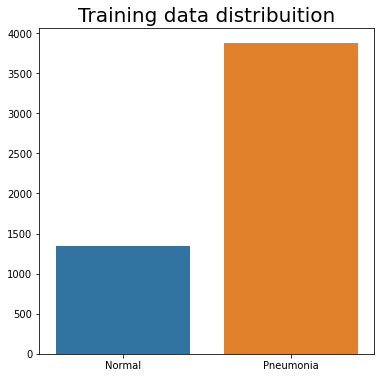

In [ ]:
df_train_unbalanced = pd.DataFrame.from_dict({ 'Normal': [n_normal], 'Pneumonia': [n_pneumonia] })

plt.figure(figsize=(6, 6))
plot = sns.barplot(data=df_train_unbalanced)
plot.set_title('Training Data Distribuition', fontsize=20)
plt.show()

### See our images

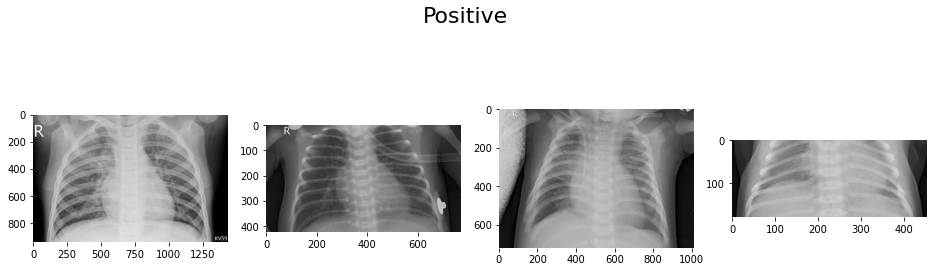

In [ ]:
path_imgs = os.listdir(path_dir_train_pneumonia)
random.shuffle(path_imgs)

fig = plt.figure(figsize=(16, 5))
fig.suptitle("Positive", size=22)

for i, image in enumerate(path_imgs[:4]):
    img_path = os.path.join(path_dir_train_pneumonia, image)
    img = cv2.imread(img_path)
    plt.subplot(1, 4, i + 1, frameon=False)
    plt.imshow(img)
fig.show()

## Build Model


### Model backbone: resnet18, pretrained

- Backbone _(feature extractor)_: __Resnet__
- We use pre-trained weights of Resnet (from `torch.models`) to increase accuracy & reduce training time.


In [ ]:

'''
	NOTE: We need to replace the original last layer
	- Last layer is a linear fully connected one with many outputs;
	- Our net needs 02 (as we have 02 classes);
	- We replace it so it becomes a binary classifier;
	- We end up with a new last layer holding the same number of inputs but only 02 outputs:
	
	NOTE: The end network has no activation function
	- For our binary classification we'd need a sigmoid activation;
	- But we skip this job as our cost function already handles this;
'''

model = models.resnet18(pretrained=True)
for params in model.parameters():	# Freeze parameters (so pre-trained convolution layers don't change)
		params.requires_grad_ = False

n_filters = model.fc.in_features
model.fc = torch.nn.Linear(n_filters, 2) # Replace last layer
model = model.to(DEVICE)

criterion = torch.nn.CrossEntropyLoss() # Loss function

# Optimization
if optim_algorithm == 'adam':
		optimizer = optim.Adam(model.parameters(), lr=learn_rate)
elif optim_algorithm == 'sgd':
		optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=momentum)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### See model

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Training

#### Train

In [ ]:
since = time.time()
best_model = copy.deepcopy(model.state_dict())
best_accuracy = 0.0
train_balances = []

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    
    # Train
    model.train()
    running_loss = 0.0
    running_corrects = 0
    running_balances = []
    
    for inputs, labels in tqdm(loader_train, total=len(loader_train)):
        running_balances.append(Counter(labels.numpy()))
        
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, y_hat = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0) # TODO: Figure this out
        running_corrects += torch.sum(y_hat == labels.data)

    epoch_loss = running_loss / n_train
    epoch_accuracy = running_corrects.double() / n_train
    train_balances.append(running_balances)
    print('Train Loss: {:.4f}; Train Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
    
    # Validate
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in loader_validation:
        
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, y_hat = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0) # TODO: Figure this out
        running_corrects += torch.sum(y_hat == labels.data)

  
    epoch_loss = running_loss / n_validation
    epoch_accuracy = running_corrects.double() / n_validation
    print('Val Loss: {:.4f}; Val Accuracy: {:.4f}'.format(epoch_loss, epoch_accuracy))
    print('-' * 40)
    
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        best_model = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
model.load_state_dict(best_model)

print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best Val Acc: {:.4f}'.format(best_accuracy))


Epoch 1/4


100%|██████████| 41/41 [02:42<00:00,  3.96s/it]


Train Loss: 0.3112; Train Accuracy: 0.8773
Val Loss: 0.3651; Val Accuracy: 0.7500
----------------------------------------
Epoch 2/4


100%|██████████| 41/41 [02:35<00:00,  3.79s/it]


Train Loss: 0.1190; Train Accuracy: 0.9563
Val Loss: 0.2133; Val Accuracy: 0.9375
----------------------------------------
Epoch 3/4


100%|██████████| 41/41 [02:29<00:00,  3.64s/it]


Train Loss: 0.0989; Train Accuracy: 0.9632
Val Loss: 0.1591; Val Accuracy: 0.9375
----------------------------------------
Epoch 4/4


100%|██████████| 41/41 [02:23<00:00,  3.51s/it]


Train Loss: 0.0790; Train Accuracy: 0.9711
Val Loss: 0.0993; Val Accuracy: 1.0000
----------------------------------------
Training complete in 10m 12s
Best Val Acc: 1.0000


#### Save classifier

In [ ]:
torch.save(model.state_dict(), path_file_model)

## Evaluation

#### Load saved model

In [ ]:
model.load_state_dict(torch.load(path_file_model))

<All keys matched successfully>

### Test

In [ ]:
since = time.time()
was_training = model.training
n_successes = 0
test_balances = []

targets = np.array([])
outputs = np.array([])
predictions = np.array([])

model.eval()
with torch.no_grad():
  for inputs, labels in tqdm(loader_test, total=len(loader_test)):
      test_balances.append(Counter(labels.numpy()))
      
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)

      output_batch = model(inputs)
      _, y_hat = torch.max(output_batch, 1)

      targets = np.append(targets, labels.cpu().numpy())
      outputs = np.append(outputs, output_batch.cpu().numpy()[:, 1])
      predictions = np.append(predictions, y_hat.cpu().numpy())
      n_successes += torch.sum(y_hat == labels.data)

model.train(mode=was_training)
test_accuracy = n_successes.double() / n_test
time_test = time.time() - since

print('Test complete in {:.0f}m {:.0f}s'.format(time_test // 60, time_test % 60))

100%|██████████| 5/5 [00:12<00:00,  2.59s/it]

Test complete in 0m 13s


### Analysis

One thing to keep in mind is that because of our goal's nature the accuracy metric is not enough to measure the model's fitness to the problem. As it is meant to be used for medical diagnosis support not all misclassifications are the same.

A false negative is muche worse than a false positive. So in our analysis we should keep in mind that besides accuracy, model sensibility a valuable measure being prefered over precision.

Accuracy: 0.9135
Precision (average): 0.9255
Recall (average): 0.6321
F1 Score (Normal): 0.8789
F1 Score (Pneumonia): 0.9327



<Figure size 432x288 with 0 Axes>

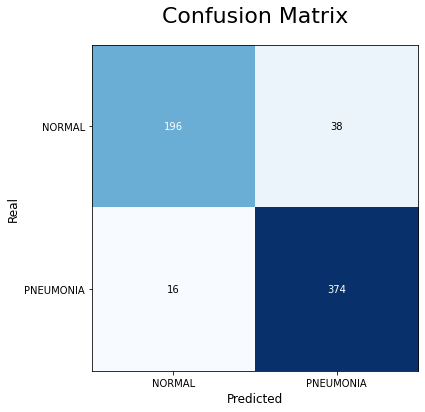

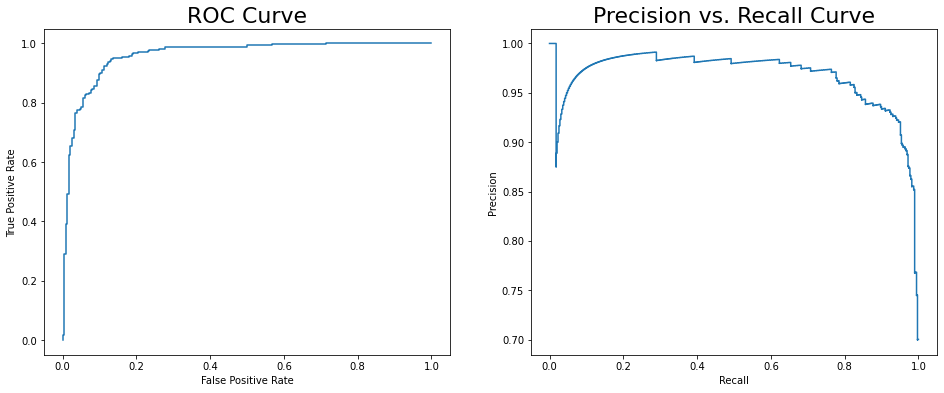

In [ ]:

f1_normal, f1_pneumonia = f1_score(targets, predictions, average=None)
precision, recall, _ = precision_recall_curve(targets, outputs, pos_label=1)

print(r"Accuracy: %.4f" % test_accuracy.item())
print(r"Precision (average): %.4f" % precision.mean())
print(r"Recall (average): %.4f" % recall.mean())
print(r"F1 Score (Normal): %.4f" % f1_normal)
print(r"F1 Score (Pneumonia): %.4f" % f1_pneumonia)
print('')

# Confusion Matrix
plt.figure()

matrix = confusion_matrix(targets, predictions)
plot_confusion_matrix(matrix, figsize=(6, 6))

plt.title('Confusion Matrix', fontsize=22)
plt.xticks(range(2), ds_train.classes, fontsize=10)
plt.yticks(range(2), ds_train.classes, fontsize=10)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.savefig(path_file_conf_matrix)
plt.show()
print('')

# ROC Curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

fpr, tpr, _ = roc_curve(targets, outputs, pos_label=1)
display_roc = RocCurveDisplay(fpr=fpr, tpr=tpr)
ax1.set_title('ROC Curve', fontsize=22)
display_roc.plot(ax=ax1)

# Precision x Recall Curve
display_precision_recall = PrecisionRecallDisplay(precision=precision, recall=recall)
ax2.set_title('Precision vs. Recall Curve', fontsize=22)
display_precision_recall.plot(ax=ax2)
plt.savefig(path_file_roc_recall)
plt.show()


